In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imaids.models import DeltaSabia
from idanalysis.analysis import Tools
import utils
import imaids
from mathphys.functions import save_pickle, load_pickle
from scipy.integrate import cumtrapz
from scipy.fftpack import fft, ifft, fftfreq


### Basic functions

In [2]:
def generate_radia_model(phase=0, dgv=0, trf_on_blocks=False):
    """."""

    delta = DeltaSabia(trf_on_blocks=trf_on_blocks)
    delta.set_cassete_positions(dp=phase, dgv=dgv)

    return delta


In [3]:
def get_cassettes_names(model):
    return list(model.cassettes_ref.keys())


In [4]:
def get_fieldmap(phase, dgv):
    fmap_fname = Tools.get_fmap_fname(utils.ID_CONFIGS, utils.MEAS_DATA_PATH,
                                      config_keys=(phase, dgv),
                                      config_dict=utils.CONFIG_DICT)
    return Tools.get_fmap(fmap_fname)


### Funtions to get field

In [5]:
def get_full_field(fmap):
    full_field = np.zeros((len(fmap.rx), len(fmap.rz), 3))
    full_field[:, :, 0]  = fmap.bx[0]
    full_field[:, :, 1]  = fmap.by[0]
    full_field[:, :, 2]  = fmap.bz[0]
    return full_field


In [6]:
def get_full_field_model(rx, rz, model):
    field_model = np.zeros((len(rx), len(rz), 3))
    for i, x in enumerate(rx):
        field_model[i, :, :] = model.get_field(x=x, y=0, z=rz, nproc=24)
    return field_model


In [7]:
def calc_field_difference(full_field_meas, delta, rx, rz):
    full_field_model = get_full_field_model(rx, rz, delta)
    full_field_model = np.swapaxes(full_field_model, 0, 1)
    field_diff = (full_field_meas - full_field_model).ravel(order='F')
    return field_diff


### Functions to construct jacobian

In [8]:
def cas_2_angle(cas):
    cas_2_angle = dict()
    cas_2_angle['cid'] = -np.pi/4
    cas_2_angle['csd'] = -3*np.pi/4
    cas_2_angle['cie'] = np.pi/4
    cas_2_angle['cse'] = 3*np.pi/4
    return cas_2_angle[cas]


In [9]:
def do_block_displacement(delta, block, cas):
    block.shift([0, -delta.gap/2, 0])
    center = np.array(block.center_point)
    center[0] = 0
    center[1] = 0
    block.shift(-center)
    block.rotate([0, 0, 0], [0, 0, 1], cas_2_angle(cas))


In [10]:
def do_block_shift(block, shift_list, cas):
    x = shift_list[0]
    y = shift_list[1]
    shiftb = np.array([x, y])

    # Apply local shift to block
    theta = cas_2_angle(cas)
    M = np.zeros((2, 2))
    M[0, 0] = np.cos(theta)
    M[0, 1] = -np.sin(theta)
    M[1, 0] = np.sin(theta)
    M[1, 1] = np.cos(theta)
    shift = np.dot(M, shiftb)
    block.shift([shift[0], shift[1], 0])


In [11]:
def calculate_jac_elements(delta, rx, cas='cid', z_range=600, nr_pts=2401):
    blocks = [
        delta.cassettes_ref[cas].blocks[block_nr] for block_nr in
        np.arange(0, 8, 1)]
    blocks += [
            delta.cassettes_ref[cas].blocks[-4],
            delta.cassettes_ref[cas].blocks[-2]]
    nr_blocks = len(blocks)

    x = rx
    z = np.linspace(-z_range/2, z_range/2, nr_pts)

    dmag = 0.04
    dshift = 0.04

    delta_shifts = [np.array([dshift, 0, 0]),
                    np.array([0, dshift, 0])]

    delta_mags = [np.array([dmag, 0, 0]),
                  np.array([0, dmag, 0]),
                  np.array([0, 0, dmag]),
                  ]

    jac_elem = np.zeros((len(z), len(x), len(delta_mags)+len(delta_shifts), nr_blocks, 3))

    for k, block in enumerate(blocks):
        print('block: ', k)
        for i, x_ in enumerate(x):
            for j, d_mag in enumerate(delta_mags):

                block.magnetization = np.array(block.magnetization) + d_mag/2
                do_block_displacement(delta, block, cas)
                field_p = block.get_field(x=x_, y=0, z=z, nproc=24)


                block.magnetization = np.array(block.magnetization) - d_mag
                do_block_displacement(delta, block, cas)
                field_n = block.get_field(x=x_, y=0, z=z, nproc=24)

                block.magnetization = np.array(block.magnetization) + d_mag/2
                do_block_displacement(delta, block, cas)

                diff = (field_p - field_n)/dmag
                jac_elem[:, i, j, k, :] = diff

            for j, d_shift in enumerate(delta_shifts):
                do_block_shift(block, d_shift/2, cas)
                field_p = block.get_field(x=x_, y=0, z=z, nproc=24)

                do_block_shift(block, -d_shift, cas)
                field_n = block.get_field(x=x_, y=0, z=z, nproc=24)

                do_block_shift(block, d_shift/2, cas)

                diff = (field_p - field_n)/dshift
                jac_elem[:, i, len(delta_mags) + j, k, :] = diff

    return jac_elem


In [12]:
def transform_cd_2_ce(jac_elem):
    jac_elem[:, :, :, :, :] = jac_elem[:, ::-1, :, :, :]  # Invert x grid

    # delta mx
    jac_elem[:, :, 0, :, 1] = -1*jac_elem[:, :, 0, :, 1]  # Change By signal
    jac_elem[:, :, 0, :, 2] = -1*jac_elem[:, :, 0, :, 2]  # Change Bz signal

    # delta my
    jac_elem[:, :, 1, :, 0] = -1*jac_elem[:, :, 1, :, 0]  # Change Bx signal

    # delta mz
    jac_elem[:, :, 2, :, 0] = -1*jac_elem[:, :, 2, :, 0]  # Change Bx signal

    # delta rx
    jac_elem[:, :, 3, :, 1] = -1*jac_elem[:, :, 3, :, 1]  # Change By signal
    jac_elem[:, :, 3, :, 2] = -1*jac_elem[:, :, 3, :, 2]  # Change Bz signal

    # delta ry
    jac_elem[:, :, 4, :, 0] = -1*jac_elem[:, :, 4, :, 0]  # Change Bx signal

    return jac_elem


In [13]:
def transform_ci_2_cs(jac_elem):
    # delta mx
    jac_elem[:, :, 0, :, 0] = -1*jac_elem[:, :, 0, :, 0]  # Change Bx signal
    jac_elem[:, :, 0, :, 2] = -1*jac_elem[:, :, 0, :, 2]  # Change Bz signal

    # delta my
    jac_elem[:, :, 1, :, 1] = -1*jac_elem[:, :, 1, :, 1]  # Change By signal

    # delta mz
    jac_elem[:, :, 2, :, 1] = -1*jac_elem[:, :, 2, :, 1]  # Change By signal

    # delta rx
    jac_elem[:, :, 3, :, 0] = -1*jac_elem[:, :, 3, :, 0]  # Change Bx signal
    jac_elem[:, :, 3, :, 2] = -1*jac_elem[:, :, 3, :, 2]  # Change Bz signal

    # delta ry
    jac_elem[:, :, 4, :, 1] = -1*jac_elem[:, :, 4, :, 1]  # Change By signal

    return jac_elem


In [14]:
def transform_cid_2_cse(jac_elem):
    jac_cie = transform_cd_2_ce(jac_elem)  # Transform to cie
    jac_cse = transform_ci_2_cs(jac_cie)  # Transform to cse
    return jac_cse


In [15]:
def create_cas_jacobian(jac_elem):
    cid = jac_elem.copy()
    cie = jac_elem.copy()
    csd = jac_elem.copy()
    cse = jac_elem.copy()

    csd = transform_ci_2_cs(csd)
    cie = transform_cd_2_ce(cie)
    cse = transform_cid_2_cse(cse)

    cas_jacobians = {
                     'cse': cse,
                     'csd': csd,
                     'cie': cie,
                     'cid': cid,
                    }
    return cas_jacobians


In [16]:
def get_block_type(block_number, nr_blocks):
    if block_number <= 3:
        block_type = block_number
    elif block_number <= nr_blocks-5:
        block_type = (block_number-4) % 4 + 4
    else:
        cont = -1*(nr_blocks-block_number-4)
        if cont % 2 != 0:
            block_type = nr_blocks-block_number-1
        elif cont == 0:
            block_type = 8
        else:
            block_type = 9
    return block_type


In [17]:
def create_jacobian(cas_jacobians, delta, rx, rz, z_range=600):
    cas_names = get_cassettes_names(delta)
    nr_pts_jac = cas_jacobians[cas_names[0]].shape[0]
    z_jac = np.linspace(-z_range/2, z_range/2, nr_pts_jac)
    nr_blocks = delta.cassettes_ref[cas_names[0]].nr_blocks

    jacobian = np.zeros((len(rz), len(rx), 3, 4*nr_blocks*5))

    for i, cas_name in enumerate(cas_names):
        cas_shift = delta.cassettes_ref[cas_name].center_point[-1]
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            block_shift = block.center_point[-1]
            bl_type = get_block_type(j, nr_blocks)

            sel = (np.abs(rz-(block_shift + cas_shift)) <= z_range/2)
            z_pts = (rz-(block_shift + cas_shift))[sel]

            for fcomp in np.arange(3):
                for x, _ in enumerate(rx):
                    for mag in np.arange(5):
                        prejac = np.interp(z_pts, z_jac,
                                           cas_jacobians[cas_name][:, x, mag, bl_type, fcomp])

                        column = 5*i*nr_blocks + 5*j + mag
                        jacobian[sel, x, fcomp, column] = prejac
    jacobian = jacobian.reshape((len(rz)*len(rx)*3, 4*nr_blocks*5), order='F')
    return jacobian


In [18]:
def calc_inverse_jacobian(jacobian, tikhonovregconst=1e-3):
    u, s, vt = np.linalg.svd(jacobian, full_matrices=False)
    # sel_svals = abs(s) > tol_svals
    # ismat = np.zeros(s.shape)
    # ismat[sel_svals] = 1/s[sel_svals]
    ismat = s/(s*s + tikhonovregconst*tikhonovregconst)
    ismat = np.diag(ismat)
    invmat = np.dot(np.dot(vt.T, ismat), u.T)
    return invmat, u, s, vt


In [19]:
def normalize_jacobian(jac_elem):
    jac_elem = np.swapaxes(jac_elem, -1, 2)
    shape = jac_elem.shape

    aux_elem = jac_elem.reshape(
        shape[0]*shape[1]*shape[2]*shape[3], 5, order='F')

    std_mag = np.std(aux_elem[:, 0])
    std_mag += np.std(aux_elem[:, 1])
    std_mag += np.std(aux_elem[:, 2])
    std_mag /= 3

    convx = std_mag/np.std(aux_elem[:, 3])
    convy = std_mag/np.std(aux_elem[:, 4])
    convx = 1
    convy = 1
    aux_elem[:, 3] *= convx
    aux_elem[:, 4] *= convy

    aux_elem = aux_elem.reshape(shape, order='F')
    jac_elem = np.swapaxes(aux_elem, -1, 2)
    return  jac_elem, convx, convy


In [20]:
def separate_jacobian(jacobian):
    idcs_magx = np.arange(0, jacobian.shape[1]-4, 5)
    idcs_magy = np.arange(1, jacobian.shape[1]-3, 5)
    idcs_magz = np.arange(2, jacobian.shape[1]-2, 5)
    idcs_shiftx = np.arange(3, jacobian.shape[1]-1, 5)
    idcs_shifty = np.arange(4, jacobian.shape[1]-0, 5)

    idcs_mag = np.sort(np.concatenate((idcs_magx, idcs_magy, idcs_magz)))
    idcs_shift = np.sort(np.concatenate((idcs_shiftx, idcs_shifty)))

    jacobian_mags = jacobian[:, idcs_mag]
    jacobian_shifts = jacobian[:, idcs_shift]
    return jacobian_mags, jacobian_shifts


### Construct jacobian

In [21]:
delta = generate_radia_model(phase=0, dgv=0)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref[cas_names[0]].nr_blocks

nr_points_z = 901
nr_points_x = 3

rx = np.linspace(-5, 5, nr_points_x)
rz = np.linspace(-900, 900, nr_points_z)

nr_pts_jac = 2401
z_range_jac = 600
jac_elem = calculate_jac_elements(delta, rx, cas='cid',
                                  z_range=z_range_jac,
                                  nr_pts=nr_pts_jac)

jac_elem_n, convx, convy = normalize_jacobian(jac_elem.copy())
cas_jacobians = create_cas_jacobian(jac_elem_n)

phase, dgv = 0, 10
delta = generate_radia_model(phase=phase, dgv=dgv)
jacobian = create_jacobian(cas_jacobians, delta, rx, rz, z_range=z_range_jac)
jacobian_mags, jacobian_shifts = separate_jacobian(jacobian)


block:  0


block:  1
block:  2
block:  3
block:  4
block:  5
block:  6
block:  7
block:  8
block:  9


### Test jacobian elements and symmetries

#### Test jacobian elements

In [22]:
%matplotlib qt5

nr_pts_jac = 2401
z_range_jac = 600

print(jac_elem.shape)
z = np.linspace(-z_range_jac/2, z_range_jac/2, nr_pts_jac)
plt.plot(z, cas_jacobians['csd'][:, 0, 0, 0, 2], '-')


(2401, 3, 5, 10, 3)


#### Test symmetries

In [ ]:
delta = generate_radia_model(phase=phase, dgv=dgv)
jac_elem_cid = calculate_jac_elements(delta, rx, rz, 'cid')

delta = generate_radia_model(phase=phase, dgv=dgv)
jac_elem_cie = calculate_jac_elements(delta, rx, rz, 'cie')

delta = generate_radia_model(phase=phase, dgv=dgv)
jac_elem_csd = calculate_jac_elements(delta, rx, rz, 'csd')

delta = generate_radia_model(phase=phase, dgv=dgv)
jac_elem_cse = calculate_jac_elements(delta, rx, rz, 'cse')

delta = generate_radia_model(phase=phase, dgv=dgv)


In [ ]:
%matplotlib inline
jac_elem_cie_2 = transform_cd_2_ce(jac_elem_cid.copy())
jac_elem_csd_2 = transform_ci_2_cs(jac_elem_cid.copy())
jac_elem_cse_2 = transform_cid_2_cse(jac_elem_cid.copy())

# The difference must be almost zero
plt.plot((jac_elem_cie_2-jac_elem_cie).ravel())
plt.plot((jac_elem_csd_2-jac_elem_csd).ravel())
plt.plot((jac_elem_cse_2-jac_elem_cse).ravel())


In [ ]:
%matplotlib qt5

# Verify spatial influence
plt.plot(rz, jac_elem_cid[:, 1, 0, 0 , 0])


#### Verify ortogonality of basis vectors

In [23]:
%matplotlib qt5
jac = jac_elem_n.swapaxes(2, -1)
shape = jac.shape

jac = jac.reshape(shape[0]*shape[1]*shape[2], shape[3], shape[4], order='F')

block = 1
plt.plot(jac[:, block, 0])
plt.plot(jac[:, block, 1])
plt.plot(jac[:, block, 2])
plt.plot(jac[:, block, 3])
plt.plot(jac[:, block, 4])

M = np.zeros((jac.shape[0], 5))
M[:, 0] = jac[:, block, 0]/np.linalg.norm(jac[:, block, 0])
M[:, 1] = jac[:, block, 1]/np.linalg.norm(jac[:, block, 1])
M[:, 2] = jac[:, block, 2]/np.linalg.norm(jac[:, block, 2])
M[:, 3] = jac[:, block, 3]/np.linalg.norm(jac[:, block, 3])
M[:, 4] = jac[:, block, 4]/np.linalg.norm(jac[:, block, 4])

res = np.dot(np.transpose(M), M)
for i in np.arange(res.shape[0]):
    print(' | ', end='')
    for j in np.arange(res.shape[1]):
        print('{:.2f}  '.format(np.abs(res[i, j])), end='')
    print('|')


 | 1.00  0.19  0.00  0.89  0.20  |
 | 0.19  1.00  0.00  0.28  0.83  |
 | 0.00  0.00  1.00  0.00  0.00  |
 | 0.89  0.28  0.00  1.00  0.37  |
 | 0.20  0.83  0.00  0.37  1.00  |


#### Verify frequency response of basis vectors

In [24]:
%matplotlib qt5
block = 1
comp = 0
axis_nr = 0
par0 = 2
par1 = 4

z = np.linspace(-z_range_jac/2, z_range_jac/2, nr_pts_jac)

signal0 = jac_elem[:, axis_nr, par0, block, comp]/np.linalg.norm(jac_elem[:, axis_nr, par0, block, comp])

signal1 = jac_elem[:, axis_nr, par1, block, comp]/np.linalg.norm(jac_elem[:, axis_nr, par1, block, comp])

omega = fftfreq(signal0.size, d=1e-3*z[1]-1e-3*z[0])
f_signal0 = fft(signal0)
f_signal1 = fft(signal1)

idx = np.argsort(omega)
omega = omega[idx]
f_signal0 = f_signal0[idx]
f_signal1 = f_signal1[idx]

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)

axs[0].plot(z, signal1)
axs[0].plot(z, signal0)
axs[0].set_xlabel('z [mm]')

axs[1].plot(omega, np.abs(f_signal1))
axs[1].plot(omega, np.abs(f_signal0))
axs[1].set_xlabel('Spatial frequency [mm ^-1]')


Text(0.5, 0, 'Spatial frequency [mm ^-1]')

### Functions to test Jacobian

#### Validate Jacobian

In [25]:
def get_jacobian_element(jacobian, cas_nr, block_nr, axis_nr, par,
                         nr_blocks, nr_points_z, nr_points_x):
    jac_column = jacobian[:, cas_nr*nr_blocks*5 + block_nr*5 + par]
    jac_elem = jac_column.reshape(nr_points_z, nr_points_x, 3, order='F')
    bx = jac_elem[: , axis_nr, 0]
    by = jac_elem[: , axis_nr, 1]
    bz = jac_elem[: , axis_nr, 2]
    return bx, by, bz


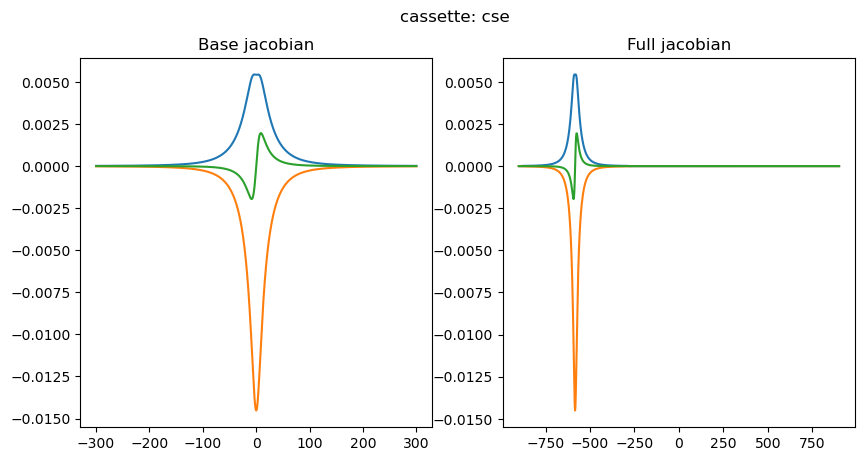

In [28]:
# Compare jacobian with jacobian elements
%matplotlib inline

z = np.linspace(-z_range_jac/2, z_range_jac/2, nr_pts_jac)

cas_nr = 0
block_nr = 0
axis_nr = 0
par = 0
cas_name = cas_names[cas_nr]


block_type = get_block_type(block_nr, nr_blocks)

bx = cas_jacobians[cas_name][:, axis_nr, par, block_type, 0]
by = cas_jacobians[cas_name][:, axis_nr, par, block_type, 1]
bz = cas_jacobians[cas_name][:, axis_nr, par, block_type, 2]
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)

fig.suptitle('cassette: {}'.format(cas_name))
axs[0].set_title('Base jacobian')
axs[0].plot(z, bx)
axs[0].plot(z, by)
axs[0].plot(z, bz)

bx, by, bz = get_jacobian_element(jacobian, cas_nr, block_nr, axis_nr, par,
                                  nr_blocks, len(rz), len(rx))
axs[1].set_title('Full jacobian')
axs[1].plot(rz, bx)
axs[1].plot(rz, by)
axs[1].plot(rz, bz)


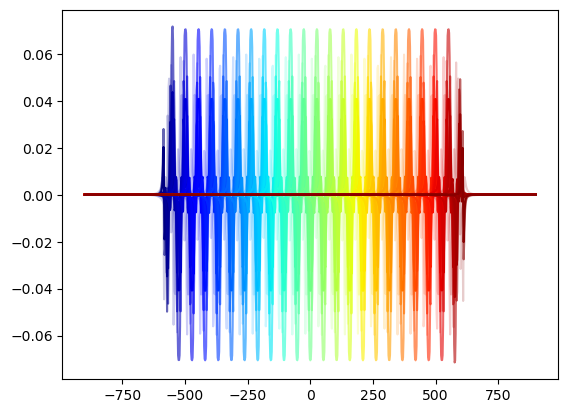

In [29]:
# Verify block translation

cas_nr = 0
axis_nr = 2
par = 4

plt.figure(1)
for block_nr in np.arange(0, 93, 1):
    bx, by, bz = get_jacobian_element(jacobian, cas_nr, block_nr, axis_nr, par,
                                      nr_blocks, len(rz), len(rx))
    plt.plot(rz, bx, color=plt.cm.jet(block_nr/93), alpha=1, label='bx')
    plt.plot(rz, by, color=plt.cm.jet(block_nr/93), alpha=.6, label='by')
    plt.plot(rz, bz, color=plt.cm.jet(block_nr/93), alpha=.2, label='bz')
plt.show()


#### Validate separated jacobians

##### Magnetization jacobian

In [30]:
def get_jacobian_mag_element(jacobian, cas_nr, block_nr, axis_nr, par,
                             nr_blocks, nr_points_z, nr_points_x):
    jac_column = jacobian[:, cas_nr*nr_blocks*3 + block_nr*3 + par]
    jac_elem = jac_column.reshape(nr_points_z, nr_points_x, 3, order='F')
    bx = jac_elem[: , axis_nr, 0]
    by = jac_elem[: , axis_nr, 1]
    bz = jac_elem[: , axis_nr, 2]
    return bx, by, bz


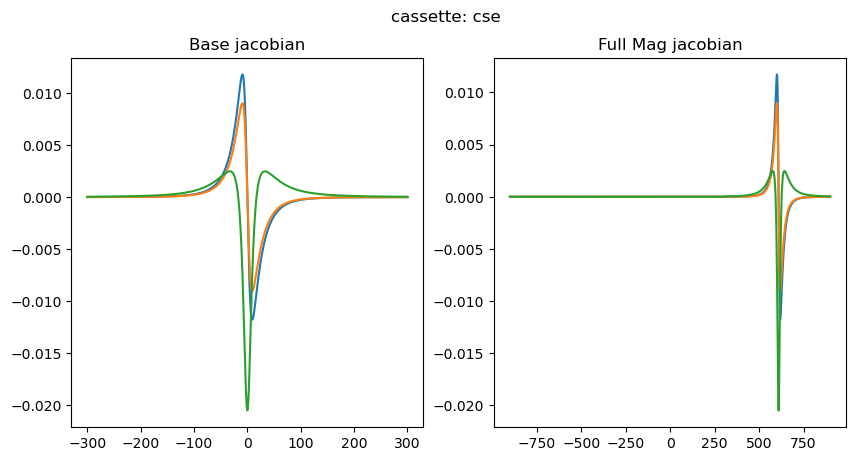

In [31]:
# Compare jacobian with jacobian elements
%matplotlib inline

z = np.linspace(-z_range_jac/2, z_range_jac/2, nr_pts_jac)

cas_nr = 0
block_nr = 92
axis_nr = 0
par = 2
cas_name = cas_names[cas_nr]


block_type = get_block_type(block_nr, nr_blocks)

bx = cas_jacobians[cas_name][:, axis_nr, par, block_type, 0]
by = cas_jacobians[cas_name][:, axis_nr, par, block_type, 1]
bz = cas_jacobians[cas_name][:, axis_nr, par, block_type, 2]
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)

fig.suptitle('cassette: {}'.format(cas_name))
axs[0].set_title('Base jacobian')
axs[0].plot(z, bx)
axs[0].plot(z, by)
axs[0].plot(z, bz)

bx, by, bz = get_jacobian_mag_element(jacobian_mags, cas_nr, block_nr,
                                      axis_nr, par, nr_blocks, len(rz),
                                      len(rx))
axs[1].set_title('Full Mag jacobian')
axs[1].plot(rz, bx)
axs[1].plot(rz, by)
axs[1].plot(rz, bz)


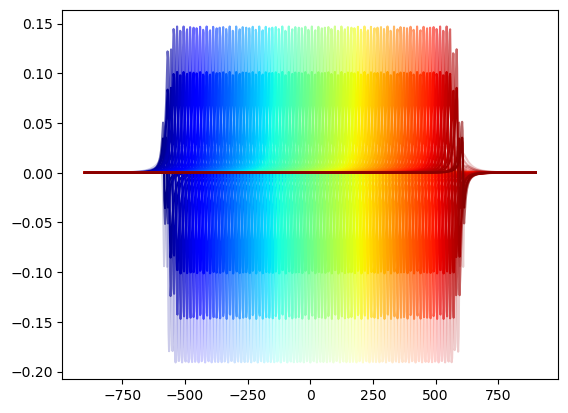

In [32]:
# Verify block translation

cas_nr = 0
axis_nr = 2
par = 2

plt.figure(1)
for block_nr in np.arange(0, 93, 1):
    bx, by, bz = get_jacobian_mag_element(jacobian_mags, cas_nr, block_nr,
                                          axis_nr, par, nr_blocks, len(rz),
                                          len(rx))
    plt.plot(rz, bx, color=plt.cm.jet(block_nr/93), alpha=1, label='bx')
    plt.plot(rz, by, color=plt.cm.jet(block_nr/93), alpha=.6, label='by')
    plt.plot(rz, bz, color=plt.cm.jet(block_nr/93), alpha=.2, label='bz')
plt.show()


##### Shift Jacobian

In [33]:
def get_jacobian_shift_element(jacobian, cas_nr, block_nr, axis_nr, par,
                               nr_blocks, nr_points_z, nr_points_x):
    jac_column = jacobian[:, cas_nr*nr_blocks*2 + block_nr*2 + par]
    jac_elem = jac_column.reshape(nr_points_z, nr_points_x, 3, order='F')
    bx = jac_elem[: , axis_nr, 0]
    by = jac_elem[: , axis_nr, 1]
    bz = jac_elem[: , axis_nr, 2]
    return bx, by, bz


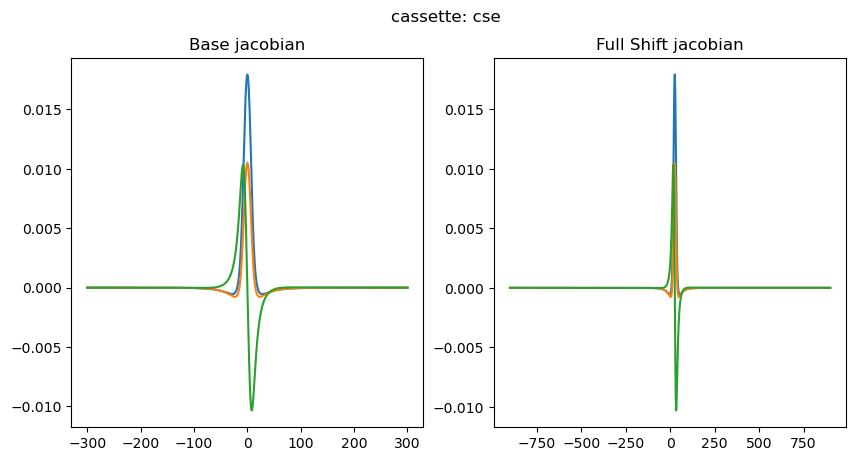

In [34]:
# Compare jacobian with jacobian elements
%matplotlib inline

z = np.linspace(-z_range_jac/2, z_range_jac/2, nr_pts_jac)

cas_nr = 0
block_nr = 47
axis_nr = 0
par = 1
cas_name = cas_names[cas_nr]


block_type = get_block_type(block_nr, nr_blocks)

bx = cas_jacobians[cas_name][:, axis_nr, par+3, block_type, 0]
by = cas_jacobians[cas_name][:, axis_nr, par+3, block_type, 1]
bz = cas_jacobians[cas_name][:, axis_nr, par+3, block_type, 2]
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)

fig.suptitle('cassette: {}'.format(cas_name))
axs[0].set_title('Base jacobian')
axs[0].plot(z, bx)
axs[0].plot(z, by)
axs[0].plot(z, bz)

bx, by, bz = get_jacobian_shift_element(jacobian_shifts, cas_nr, block_nr,
                                      axis_nr, par, nr_blocks, len(rz),
                                      len(rx))
axs[1].set_title('Full Shift jacobian')
axs[1].plot(rz, bx)
axs[1].plot(rz, by)
axs[1].plot(rz, bz)


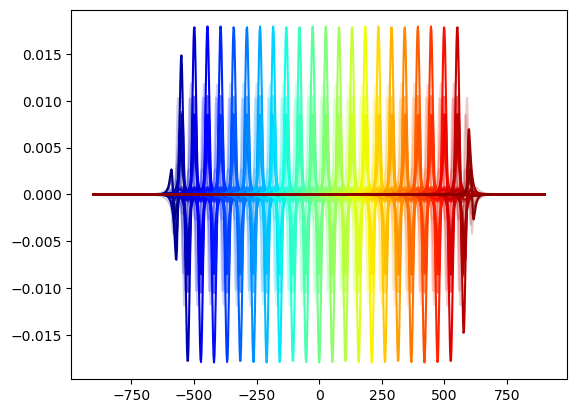

In [35]:
# Verify block translation

cas_nr = 0
axis_nr = 0
par = 1

plt.figure(1)
for block_nr in np.arange(0, 93, 1):
    bx, by, bz = get_jacobian_shift_element(jacobian_shifts, cas_nr, block_nr,
                                            axis_nr, par, nr_blocks, len(rz),
                                            len(rx))
    plt.plot(rz, bx, color=plt.cm.jet(block_nr/93), alpha=1, label='bx')
    plt.plot(rz, by, color=plt.cm.jet(block_nr/93), alpha=.6, label='by')
    plt.plot(rz, bz, color=plt.cm.jet(block_nr/93), alpha=.2, label='bz')
plt.show()


#### Calculate Inverses

##### Full jacobian

In [22]:
invmat, u, s, vt = calc_inverse_jacobian(jacobian, tikhonovregconst=0.0092)


In [37]:
%matplotlib qt5
plt.plot(np.log10(s), '.')


In [38]:
%matplotlib qt5
plt.plot(s, '.')


##### Mag Jacobian

In [23]:
invmat_mag, u_mag, s_mag, vt_mag = calc_inverse_jacobian(
                                        jacobian_mags,
                                        tikhonovregconst=0.04)


In [40]:
%matplotlib qt5
plt.plot(np.log10(s_mag), '.')


In [41]:
%matplotlib qt5
plt.plot(s_mag, '.')


##### Shift Jacobian

In [24]:
invmat_st, u_st, s_st, vt_st = calc_inverse_jacobian(jacobian_shifts,
                                                     tikhonovregconst=0.04)


In [43]:
%matplotlib qt5
plt.plot(np.log10(s_st), '.')


In [44]:
%matplotlib qt5
plt.plot(s_st, '.')


### Tests with model with errors

#### Full jacobian

In [25]:
# Generate model with errors
delta2 = generate_radia_model(phase=phase, dgv=dgv, trf_on_blocks=False)
print(cas_names)
mag_dict = dict()
mag_error = dict()
error_dict = dict()
for i, cas_name in enumerate(cas_names):
        mag_list = list()
        mag_error_list = list()
        error_list = list()
        for j, block in enumerate(delta2.cassettes_ref[cas_name].blocks):

                error = 1*np.random.rand(3)
                mag_list.append(1e0*np.array(block.magnetization) + error)
                mag_error_list.append(error)
                error_list.append(list(.8*np.random.rand(2)) + [0])

        mag_dict[cas_name] = mag_list
        mag_error[cas_name] = mag_error_list
        error_dict[cas_name] = error_list
delta2.create_radia_object(magnetization_dict=mag_dict,
                           position_err_dict=error_dict)
delta2.set_cassete_positions(dp=phase, dgv=dgv)
full_field_meas = get_full_field_model(rx, rz, delta2)
full_field_meas = np.swapaxes(full_field_meas, 0, 1)


['cse', 'csd', 'cie', 'cid']


In [26]:
# Generate nominal model
delta_nominal = generate_radia_model()
full_field_model0 = get_full_field_model(rx, rz, delta_nominal)
full_field_model0 = np.swapaxes(full_field_model0, 0, 1)
delta_field_model = full_field_meas-full_field_model0


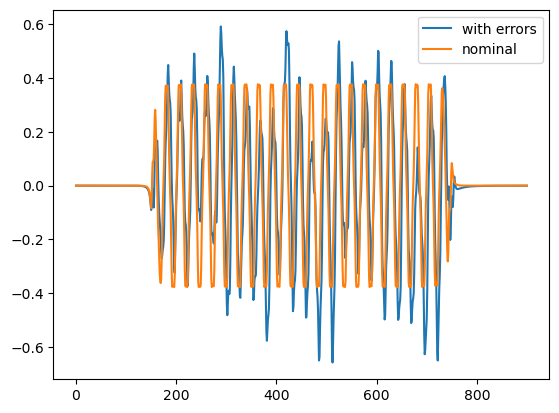

In [27]:
plt.figure(1)
plt.plot(full_field_meas[:, 0, 0], label='with errors')
plt.plot(full_field_model0[:, 0, 0], label='nominal')
plt.legend()


In [28]:
# get delta vector from model with errors
deltas = np.zeros(93*4*5)
for i, key in enumerate(mag_error.keys()):
    for blck in np.arange(len(mag_error[key])):
        for mag in np.arange(len(mag_error[key][blck])):
            deltas[i*93*5 + blck*5 + mag] = mag_error[key][blck][mag]
        for shift in np.arange(len(error_dict[key][blck])-1):
            if shift == 0:
                fac = convx
            elif shift == 1:
                fac = convy
            deltas[i*93*5 + blck*5 + 3 + shift] = error_dict[key][blck][shift]*1/fac


In [29]:
deltas[0:100]


array([8.78583399e-01, 5.43745523e-01, 2.11415343e-01, 7.31917062e-02,
       5.09550545e-01, 2.58939874e-01, 7.58059165e-01, 6.59098995e-02,
       6.83248984e-01, 5.91489257e-01, 6.59319843e-01, 2.63609175e-01,
       8.80516828e-01, 7.97980549e-01, 4.38849726e-01, 9.82255150e-01,
       4.45604552e-01, 3.22726914e-01, 6.85249197e-01, 1.56843888e-01,
       5.47691841e-01, 7.08052104e-02, 6.93068356e-01, 1.88313734e-01,
       1.82728474e-03, 7.05645984e-01, 8.25898140e-01, 1.94100407e-01,
       5.73522466e-01, 6.42663980e-01, 5.79433296e-02, 3.56363167e-01,
       9.81075636e-01, 3.87107112e-01, 4.78775425e-02, 7.86373661e-01,
       5.62258683e-01, 5.81252882e-02, 2.91921366e-01, 1.92284849e-01,
       8.33187743e-01, 4.95060256e-02, 8.26418233e-01, 5.45142455e-01,
       7.94553997e-01, 6.82174580e-01, 7.47058463e-01, 5.25123753e-01,
       2.76259950e-01, 3.59837854e-01, 6.51535777e-01, 4.21074233e-01,
       1.18714056e-01, 2.28973620e-01, 5.91926839e-01, 7.08141420e-01,
      

In [30]:
delta_field_jac = np.dot(jacobian, deltas)
delta_field_model = delta_field_model.ravel(order='F')


In [31]:
%matplotlib qt5
diff = delta_field_jac-delta_field_model
std = np.std(diff)
label = 'Difference -> std = {:.2f} G'.format(1e4*std)
plt.figure(2)
plt.title(r'Jacobian $\Delta$B vs Model $\Delta$B')
plt.plot(delta_field_jac, label='Jacobian')
plt.plot(delta_field_model, label='Model')
plt.plot(diff, label=label)
plt.ylabel('Bz [T]')
plt.xlabel('rz [mm]')
plt.legend()


In [ ]:
deltas_jac = np.dot(invmat, delta_field_model)
plt.figure(1)
plt.plot(deltas, 'o-')
plt.plot(deltas_jac, '.-')


In [ ]:
#  create radia model
imaids.utils.set_len_tol(5e-10, 5e-10)
delta = generate_radia_model(phase=phase, dgv=dgv)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref['cid'].nr_blocks

residue = list()
for k in range(50):
    print('iteraction: ', k)
    field_diff = calc_field_difference(full_field_meas, delta, rx, rz)
    residue_ = np.std(field_diff)
    residue.append(residue_)
    print(residue_)

    deltas = 0.2*np.dot(invmat, field_diff)
    deltas = deltas.reshape((len(cas_names), nr_blocks, 5))
    mag_dict = dict()
    error_dict = dict()
    cas_names = get_cassettes_names(delta)
    for i, cas_name in enumerate(cas_names):
        mag_list = list()
        error_list = list()
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            mag_list.append(np.array(block.magnetization) + deltas[i, j, 0:3])

            previous_error = np.array(delta.position_err_dict[cas_name][j])
            error_new = np.array([deltas[i, j, 3]*convx, deltas[i, j, 4]*convy, 0]) + previous_error

            error_list.append(list(error_new))

        mag_dict[cas_name] = mag_list
        error_dict[cas_name] = error_list
    delta.create_radia_object(magnetization_dict=mag_dict,
                              position_err_dict=error_dict)
    delta.set_cassete_positions(dp=phase, dgv=dgv)


In [ ]:
full_field_model = get_full_field_model(rx, rz, delta)
full_field_model = np.swapaxes(full_field_model, 0, 1)


In [ ]:
mag_final = np.zeros((4, 93, 3))
mag_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       mag_final[i, j, :] = block.magnetization
       mag_goal[i, j, :] = delta2.cassettes_ref[cas].blocks[j].magnetization


In [ ]:
mag = 0
cas = 0
plt.title('x magnetization - CSE')
plt.plot(mag_goal[cas,:, mag], 'o-', label='Goal magnetization')
plt.plot(mag_final[cas,:, mag], '.-', label='Fitted magnetization')
plt.xlabel('Block number')
plt.ylabel('Remanent magnetization [T]')
plt.legend()


In [ ]:
error_final = np.zeros((4, 93, 3))
error_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       error_final[i, j, :] = np.array(delta.position_err_dict[cas][j])
       error_goal[i, j, :] = np.array(delta2.position_err_dict[cas][j])


In [ ]:
dim = 0
cas = 1
# plt.title('x magnetization - CSE')
plt.plot(error_goal[cas,:, dim], 'o-', label='Goal error')
plt.plot(error_final[cas,:, dim], '.-', label='Fitted error')
plt.xlabel('Block number')
plt.ylabel('Block shift [mm]')
plt.legend()
plt.show()


In [ ]:
plt.plot(full_field_meas[:, 0, 2])
plt.plot(full_field_model[:, 0, 2])


#### Mag jacobian

In [32]:
# Generate model with errors
delta2 = generate_radia_model(phase=phase, dgv=dgv, trf_on_blocks=False)
print(cas_names)
mag_dict = dict()
mag_error = dict()
error_dict = dict()
for i, cas_name in enumerate(cas_names):
        mag_list = list()
        mag_error_list = list()
        error_list = list()
        for j, block in enumerate(delta2.cassettes_ref[cas_name].blocks):

                error = 1*np.random.rand(3)
                mag_list.append(1e0*np.array(block.magnetization) + error)
                mag_error_list.append(error)
                error_list.append(list(.0*np.random.rand(2)) + [0])

        mag_dict[cas_name] = mag_list
        mag_error[cas_name] = mag_error_list
        error_dict[cas_name] = error_list
delta2.create_radia_object(magnetization_dict=mag_dict,
                           position_err_dict=error_dict)
delta2.set_cassete_positions(dp=phase, dgv=dgv)
full_field_meas = get_full_field_model(rx, rz, delta2)
full_field_meas = np.swapaxes(full_field_meas, 0, 1)


['cse', 'csd', 'cie', 'cid']


In [33]:
# Generate nominal model
delta_nominal = generate_radia_model()
full_field_model0 = get_full_field_model(rx, rz, delta_nominal)
full_field_model0 = np.swapaxes(full_field_model0, 0, 1)
delta_field_model = full_field_meas-full_field_model0


In [34]:
plt.figure(1)
plt.plot(full_field_meas[:, 0, 2], label='with errors')
plt.plot(full_field_model0[:, 0, 2], label='nominal')
plt.legend()


In [35]:
# get delta vector from model with errors
deltas = np.zeros(93*4*3)
for i, key in enumerate(mag_error.keys()):
    for blck in np.arange(len(mag_error[key])):
        for mag in np.arange(len(mag_error[key][blck])):
            deltas[i*93*3 + blck*3 + mag] = mag_error[key][blck][mag]


In [73]:
deltas[0:100]


array([0.19047005, 0.16341007, 0.29500985, 0.32305291, 0.76979374,
       0.57433463, 0.04204316, 0.83750143, 0.86794418, 0.05493458,
       0.81105388, 0.89750025, 0.65892984, 0.67704577, 0.56093651,
       0.1791027 , 0.62442671, 0.12798383, 0.09327881, 0.36154861,
       0.99430011, 0.90043114, 0.50408766, 0.5309878 , 0.80809477,
       0.80891766, 0.85144375, 0.24995188, 0.10374037, 0.66177495,
       0.91748675, 0.29841922, 0.69910331, 0.12907107, 0.92002884,
       0.14148392, 0.33985753, 0.38638855, 0.08813112, 0.62098066,
       0.71762728, 0.40426651, 0.80848613, 0.37079245, 0.80353105,
       0.63793954, 0.42064394, 0.94990656, 0.03957448, 0.71162872,
       0.54974899, 0.26204804, 0.98452634, 0.54563105, 0.87771068,
       0.44278091, 0.33537013, 0.40149765, 0.01314889, 0.80317615,
       0.61416926, 0.67521409, 0.76568727, 0.24239122, 0.11681231,
       0.17942644, 0.39004375, 0.2876656 , 0.82305367, 0.25458449,
       0.53821989, 0.33474367, 0.6299218 , 0.12039862, 0.23356

In [36]:
delta_field_jac = np.dot(jacobian_mags, deltas)
delta_field_model = delta_field_model.ravel(order='F')


In [38]:
%matplotlib qt5
diff = delta_field_jac-delta_field_model
std = np.std(diff)
label = 'Difference -> std = {:.2f} G'.format(1e4*std)
plt.figure(2)
plt.title(r'Jacobian $\Delta$B vs Model $\Delta$B')
plt.plot(delta_field_jac, label='Jacobian')
plt.plot(delta_field_model, label='Model')
plt.plot(diff, label=label)
plt.ylabel('Bz [T]')
plt.xlabel('rz [mm]')
plt.legend()


In [ ]:
deltas_jac = np.dot(invmat_mag, delta_field_model)
plt.figure(1)
plt.plot(deltas, 'o-')
plt.plot(deltas_jac, '.-')


In [ ]:
#  create radia model
imaids.utils.set_len_tol(5e-10, 5e-10)
delta = generate_radia_model(phase=phase, dgv=dgv)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref['cid'].nr_blocks

residue = list()
for k in range(20):
    print('iteraction: ', k)
    field_diff = calc_field_difference(full_field_meas, delta, rx, rz)
    residue_ = np.std(field_diff)
    residue.append(residue_)
    print(residue_)

    deltas = 1*np.dot(invmat_mag, field_diff)
    deltas = deltas.reshape((len(cas_names), nr_blocks, 3))
    mag_dict = dict()
    cas_names = get_cassettes_names(delta)
    for i, cas_name in enumerate(cas_names):
        mag_list = list()
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            mag_list.append(np.array(block.magnetization) + deltas[i, j, :])

        mag_dict[cas_name] = mag_list
    delta.create_radia_object(magnetization_dict=mag_dict)
    delta.set_cassete_positions(dp=phase, dgv=dgv)


In [ ]:
full_field_model = get_full_field_model(rx, rz, delta)
full_field_model = np.swapaxes(full_field_model, 0, 1)


In [ ]:
mag_final = np.zeros((4, 93, 3))
mag_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       mag_final[i, j, :] = block.magnetization
       mag_goal[i, j, :] = delta2.cassettes_ref[cas].blocks[j].magnetization


In [ ]:
mag = 1
cas = 0
plt.title('x magnetization - CSE')
plt.plot(mag_goal[cas,:, mag], 'o-', label='Goal magnetization')
plt.plot(mag_final[cas,:, mag], '.-', label='Fitted magnetization')
plt.xlabel('Block number')
plt.ylabel('Remanent magnetization [T]')
plt.legend()


In [ ]:
error_final = np.zeros((4, 93, 3))
error_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       error_final[i, j, :] = np.array(delta.position_err_dict[cas][j])
       error_goal[i, j, :] = np.array(delta2.position_err_dict[cas][j])


In [ ]:
dim = 0
cas = 3
# plt.title('x magnetization - CSE')
plt.plot(error_goal[cas,:, dim], 'o-', label='Goal error')
plt.plot(error_final[cas,:, dim], '.-', label='Fitted error')
plt.xlabel('Block number')
plt.ylabel('Block shift [mm]')
plt.legend()
plt.show()


In [ ]:
plt.plot(full_field_meas[:, 0, 0])
plt.plot(full_field_model[:, 0, 0])


#### Shift Jacobian

In [76]:
# Generate model with errors
delta2 = generate_radia_model(phase=phase, dgv=dgv, trf_on_blocks=False)
print(cas_names)
mag_dict = dict()
mag_error = dict()
error_dict = dict()
for i, cas_name in enumerate(cas_names):
        mag_list = list()
        mag_error_list = list()
        error_list = list()
        for j, block in enumerate(delta2.cassettes_ref[cas_name].blocks):

                error = .0*np.random.rand(3)
                mag_list.append(1e0*np.array(block.magnetization) + error)
                mag_error_list.append(error)
                error_list.append(list(.8*np.random.rand(2)) + [0])

        mag_dict[cas_name] = mag_list
        mag_error[cas_name] = mag_error_list
        error_dict[cas_name] = error_list
delta2.create_radia_object(magnetization_dict=mag_dict,
                           position_err_dict=error_dict)
delta2.set_cassete_positions(dp=phase, dgv=dgv)
full_field_meas = get_full_field_model(rx, rz, delta2)
full_field_meas = np.swapaxes(full_field_meas, 0, 1)


['cse', 'csd', 'cie', 'cid']


In [77]:
# Generate nominal model
delta_nominal = generate_radia_model()
full_field_model0 = get_full_field_model(rx, rz, delta_nominal)
full_field_model0 = np.swapaxes(full_field_model0, 0, 1)
delta_field_model = full_field_meas-full_field_model0


In [ ]:
plt.figure(1)
plt.plot(full_field_meas[:, 0, 2], label='with errors')
plt.plot(full_field_model0[:, 0, 2], label='nominal')
plt.legend()


In [78]:
# get delta vector from model with errors
deltas = np.zeros(93*4*2)
for i, key in enumerate(mag_error.keys()):
    for blck in np.arange(len(mag_error[key])):
        for shift in np.arange(len(error_dict[key][blck])-1):
            deltas[i*93*2 + blck*2 + shift] = error_dict[key][blck][shift]


In [79]:
deltas[0:100]


array([0.13042347, 0.07534199, 0.52757349, 0.66400509, 0.22946309,
       0.74081386, 0.08122869, 0.78717029, 0.20037207, 0.20003349,
       0.27444928, 0.2666286 , 0.68738886, 0.67917857, 0.04653287,
       0.52142969, 0.67195655, 0.07543437, 0.26058483, 0.56703219,
       0.69694711, 0.49368768, 0.18451628, 0.17929831, 0.54160481,
       0.23210664, 0.71911586, 0.22603818, 0.22749163, 0.41767591,
       0.51636787, 0.55635127, 0.33719337, 0.78082161, 0.56930422,
       0.10389891, 0.68606839, 0.51071004, 0.38812775, 0.54020743,
       0.03547738, 0.70603721, 0.45363731, 0.05939173, 0.33266634,
       0.29485284, 0.60333608, 0.13313644, 0.72266434, 0.31760135,
       0.77071016, 0.24504193, 0.42144863, 0.28734931, 0.37215511,
       0.42867153, 0.18906569, 0.6017321 , 0.23198388, 0.00777096,
       0.33340689, 0.30022774, 0.25310818, 0.53125521, 0.2339394 ,
       0.56097594, 0.1501982 , 0.58394107, 0.10009749, 0.49243983,
       0.54961853, 0.34882581, 0.6299924 , 0.46431188, 0.09477

In [80]:
delta_field_jac = np.dot(jacobian_shifts, deltas)
delta_field_model = delta_field_model.ravel(order='F')


In [82]:
%matplotlib qt5
diff = delta_field_jac-delta_field_model
std = np.std(diff)
label = 'Difference -> std = {:.2f} G'.format(1e4*std)
plt.figure(2)
plt.title(r'Jacobian $\Delta$B vs Model $\Delta$B')
plt.plot(delta_field_jac, label='Jacobian')
plt.plot(delta_field_model, label='Model')
plt.plot(diff, label=label)
plt.ylabel('Bz [T]')
plt.xlabel('rz [mm]')
plt.legend()


In [ ]:
deltas_jac = np.dot(invmat_st, delta_field_model)
plt.figure(1)
plt.plot(deltas, 'o-')
plt.plot(deltas_jac, '.-')


In [ ]:
#  create radia model
imaids.utils.set_len_tol(5e-10, 5e-10)
delta = generate_radia_model(phase=phase, dgv=dgv)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref['cid'].nr_blocks

residue = list()
for k in range(20):
    print('iteraction: ', k)
    field_diff = calc_field_difference(full_field_meas, delta, rx, rz)
    residue_ = np.std(field_diff)
    residue.append(residue_)
    print(residue_)

    deltas = 0.2*np.dot(invmat_st, field_diff)
    deltas = deltas.reshape((len(cas_names), nr_blocks, 2))
    error_dict = dict()
    cas_names = get_cassettes_names(delta)
    for i, cas_name in enumerate(cas_names):
        error_list = list()
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            previous_error = np.array(delta.position_err_dict[cas_name][j])
            error_new = np.array([deltas[i, j, 0], deltas[i, j, 1], 0]) + previous_error

            error_list.append(list(error_new))
        error_dict[cas_name] = error_list
    delta.create_radia_object(position_err_dict=error_dict)
    delta.set_cassete_positions(dp=phase, dgv=dgv)


In [ ]:
full_field_model = get_full_field_model(rx, rz, delta)
full_field_model = np.swapaxes(full_field_model, 0, 1)


In [ ]:
mag_final = np.zeros((4, 93, 3))
mag_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       mag_final[i, j, :] = block.magnetization
       mag_goal[i, j, :] = delta2.cassettes_ref[cas].blocks[j].magnetization


In [ ]:
mag = 0
cas = 0
plt.title('x magnetization - CSE')
plt.plot(mag_goal[cas,:, mag], 'o-', label='Goal magnetization')
plt.plot(mag_final[cas,:, mag], '.-', label='Fitted magnetization')
plt.xlabel('Block number')
plt.ylabel('Remanent magnetization [T]')
plt.legend()


In [ ]:
error_final = np.zeros((4, 93, 3))
error_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       error_final[i, j, :] = np.array(delta.position_err_dict[cas][j])
       error_goal[i, j, :] = np.array(delta2.position_err_dict[cas][j])


In [ ]:
dim = 0
cas = 0
# plt.title('x magnetization - CSE')
plt.plot(error_goal[cas,:, dim], 'o-', label='Goal error')
plt.plot(error_final[cas,:, dim], '.-', label='Fitted error')
plt.xlabel('Block number')
plt.ylabel('Block shift [mm]')
plt.legend()
plt.show()


In [ ]:
plt.plot(full_field_meas[:, 2, 1])
plt.plot(full_field_model[:, 2, 1])


#### Separated jacobians

In [ ]:
# Generate model with errors
delta2 = generate_radia_model(phase=phase, dgv=dgv, trf_on_blocks=False)
print(cas_names)
mag_dict = dict()
mag_error = dict()
error_dict = dict()
for i, cas_name in enumerate(cas_names):
        mag_list = list()
        mag_error_list = list()
        error_list = list()
        for j, block in enumerate(delta2.cassettes_ref[cas_name].blocks):

                error = 1*np.random.rand(3)
                mag_list.append(1e0*np.array(block.magnetization) + error)
                mag_error_list.append(error)
                error_list.append(list(.8*np.random.rand(2)) + [0])

        mag_dict[cas_name] = mag_list
        mag_error[cas_name] = mag_error_list
        error_dict[cas_name] = error_list
delta2.create_radia_object(magnetization_dict=mag_dict,
                           position_err_dict=error_dict)
delta2.set_cassete_positions(dp=phase, dgv=dgv)
full_field_meas = get_full_field_model(rx, rz, delta2)
full_field_meas = np.swapaxes(full_field_meas, 0, 1)


In [ ]:
# Generate nominal model
delta_nominal = generate_radia_model()
full_field_model0 = get_full_field_model(rx, rz, delta_nominal)
full_field_model0 = np.swapaxes(full_field_model0, 0, 1)
delta_field_model = full_field_meas-full_field_model0


In [ ]:
plt.figure(1)
plt.plot(full_field_meas[:, 0, 2], label='with errors')
plt.plot(full_field_model0[:, 0, 2], label='nominal')
plt.legend()


In [ ]:
#  create radia model
imaids.utils.set_len_tol(5e-10, 5e-10)
delta = generate_radia_model(phase=phase, dgv=dgv)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref['cid'].nr_blocks

residue = list()
for k in range(20):
    print('iteraction mag: ', k)
    field_diff = calc_field_difference(full_field_meas, delta, rx, rz)
    residue_ = np.std(field_diff)
    residue.append(residue_)
    print(residue_)

    deltas = 1*np.dot(invmat_mag, field_diff)
    deltas = deltas.reshape((len(cas_names), nr_blocks, 3))
    mag_dict = dict()
    cas_names = get_cassettes_names(delta)
    for i, cas_name in enumerate(cas_names):
        mag_list = list()
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            mag_list.append(np.array(block.magnetization) + deltas[i, j, :])

        mag_dict[cas_name] = mag_list
    delta.create_radia_object(magnetization_dict=mag_dict)
    delta.set_cassete_positions(dp=phase, dgv=dgv)

for k in range(20):
    print('iteraction shift: ', k)
    field_diff = calc_field_difference(full_field_meas, delta, rx, rz)
    residue_ = np.std(field_diff)
    residue.append(residue_)
    print(residue_)

    deltas = 0.2*np.dot(invmat_st, field_diff)
    deltas = deltas.reshape((len(cas_names), nr_blocks, 2))
    error_dict = dict()
    cas_names = get_cassettes_names(delta)
    for i, cas_name in enumerate(cas_names):
        error_list = list()
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            previous_error = np.array(delta.position_err_dict[cas_name][j])
            error_new = np.array([deltas[i, j, 0], deltas[i, j, 1], 0]) + previous_error

            error_list.append(list(error_new))
        error_dict[cas_name] = error_list
    delta.create_radia_object(position_err_dict=error_dict)
    delta.set_cassete_positions(dp=phase, dgv=dgv)


In [ ]:
full_field_model = get_full_field_model(rx, rz, delta)
full_field_model = np.swapaxes(full_field_model, 0, 1)


In [ ]:
mag_final = np.zeros((4, 93, 3))
mag_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       mag_final[i, j, :] = block.magnetization
       mag_goal[i, j, :] = delta2.cassettes_ref[cas].blocks[j].magnetization


In [ ]:
mag = 1
cas = 0
plt.title('x magnetization - CSE')
plt.plot(mag_goal[cas,:, mag], 'o-', label='Goal magnetization')
plt.plot(mag_final[cas,:, mag], '.-', label='Fitted magnetization')
plt.xlabel('Block number')
plt.ylabel('Remanent magnetization [T]')
plt.legend()


In [ ]:
error_final = np.zeros((4, 93, 3))
error_goal = np.zeros((4, 93, 3))
for i, cas in enumerate(cas_names):
    for j, block in enumerate(delta.cassettes_ref[cas].blocks):
       error_final[i, j, :] = np.array(delta.position_err_dict[cas][j])
       error_goal[i, j, :] = np.array(delta2.position_err_dict[cas][j])


In [ ]:
dim = 1
cas = 3
# plt.title('x magnetization - CSE')
plt.plot(error_goal[cas,:, dim], 'o-', label='Goal error')
plt.plot(error_final[cas,:, dim], '.-', label='Fitted error')
plt.xlabel('Block number')
plt.ylabel('Block shift [mm]')
plt.legend()
plt.show()


In [ ]:
plt.plot(full_field_meas[:, 0, 0])
plt.plot(full_field_model[:, 0, 0])


# Tests with fieldmap

In [ ]:
phase = 0
dgv = 0
delta = generate_radia_model(phase=phase, dgv=dgv)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref[cas_names[0]].nr_blocks

# Load fmap
fmap = get_fieldmap(phase=phase, dgv=dgv)
rx = fmap.rx
ry = fmap.ry
rz = fmap.rz
full_field_meas = get_full_field(fmap)
full_field_meas = np.swapaxes(full_field_meas, 0, 1)


nr_points_z = len(rz)
nr_points_x = len(rx)

nr_pts_jac = 2401
z_range_jac = 600
jac_elem = calculate_jac_elements(delta, rx, cas='cid',
                                  z_range=z_range_jac,
                                  nr_pts=nr_pts_jac)

jac_elem_n, convx, convy = normalize_jacobian(jac_elem.copy())
cas_jacobians = create_cas_jacobian(jac_elem_n)

delta = generate_radia_model(phase=0, dgv=0)
jacobian = create_jacobian(cas_jacobians, delta, rx, rz, z_range=z_range_jac)


In [ ]:
invmat, u, s, vt = calc_inverse_jacobian(jacobian, tikhonovregconst=0.022)


In [ ]:
%matplotlib qt5
plt.plot(s, '.')


In [ ]:
#  create radia model
imaids.utils.set_len_tol(5e-10, 5e-10)
delta = generate_radia_model(phase=phase, dgv=dgv)
cas_names = get_cassettes_names(delta)
nr_blocks = delta.cassettes_ref['cid'].nr_blocks

residue = list()
for k in range(20):
    print('iteraction: ', k)
    field_diff = calc_field_difference(full_field_meas, delta, rx, rz)
    residue_ = np.std(field_diff)
    residue.append(residue_)
    print(residue_)

    deltas = 0.2*np.dot(invmat, field_diff)
    deltas = deltas.reshape((len(cas_names), nr_blocks, 5))
    mag_dict = dict()
    error_dict = dict()
    cas_names = get_cassettes_names(delta)
    for i, cas_name in enumerate(cas_names):
        mag_list = list()
        error_list = list()
        for j, block in enumerate(delta.cassettes_ref[cas_name].blocks):
            mag_list.append(np.array(block.magnetization) + deltas[i, j, 0:3])

            previous_error = np.array(delta.position_err_dict[cas_name][j])
            error_new = np.array([deltas[i, j, 3]*convx, deltas[i, j, 4]*convy, 0]) + previous_error

            error_list.append(list(error_new))

        mag_dict[cas_name] = mag_list
        error_dict[cas_name] = error_list
    delta.create_radia_object(magnetization_dict=mag_dict,
                              position_err_dict=error_dict)
    delta.set_cassete_positions(dp=phase, dgv=dgv)
